
<h2 style="text-align: center"> Training to Inferencing with Intel Asset </h2>
<h3 style="text-align: center">Intel’s new software platform for building computer vision models in a fraction of the time and with less data. The platform eases laborious data labeling, model training and optimization tasks across the AI model development process, empowering teams to produce custom AI models at scale.</h3>

<h4 style="text-align: center"> <a href="https://geti.intel.com/"> https://geti.intel.com </a> </h4>


|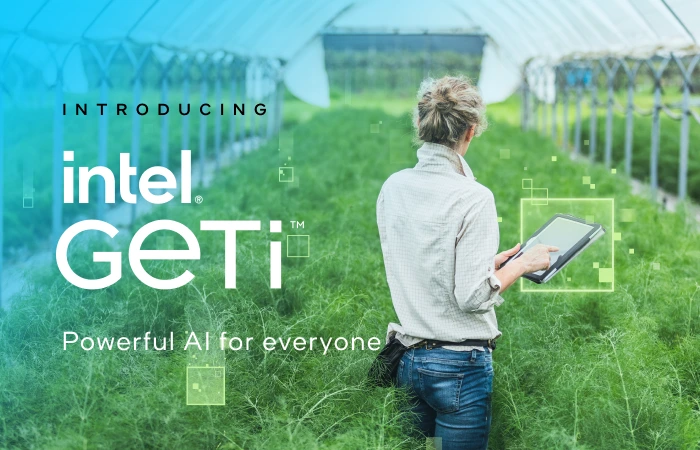| 
|:--:| 
| *Intel® Geti™ Platform* |


<h1 style="text-align: center"> Get familiar with Intel® Geti™ SDK</h1>

### Step 1: Install Intel® Geti™ SDK & Initialize Dependencies

In [ ]:
#!pip install geti-sdk==1.5.8

### Step 2: Access Intel® Geti™ Instance & Generate Personal Access Token
1. Login into https://192.168.xx.xx <br/>
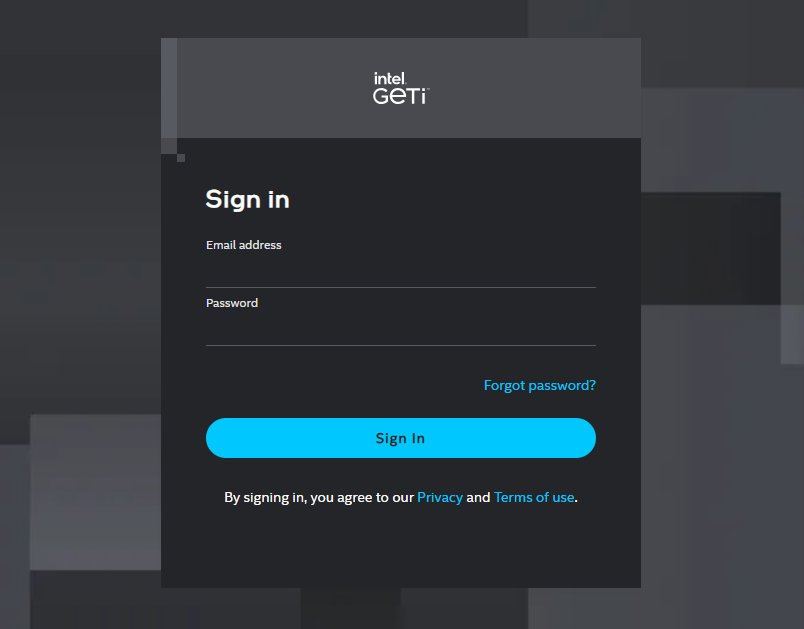

2. Create Personal Access Token </br>
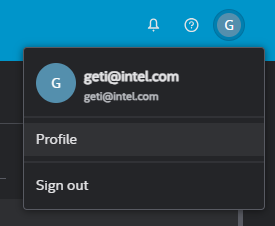  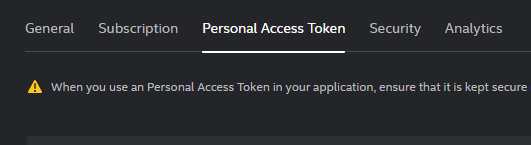

3. Copy Personal Access Token (b2RXugnVm66HdpVRu1ab9yBeZlaFLL1R:rATdYS8Kne1OzoISKSFSrxULYkeo5jvo) </br>
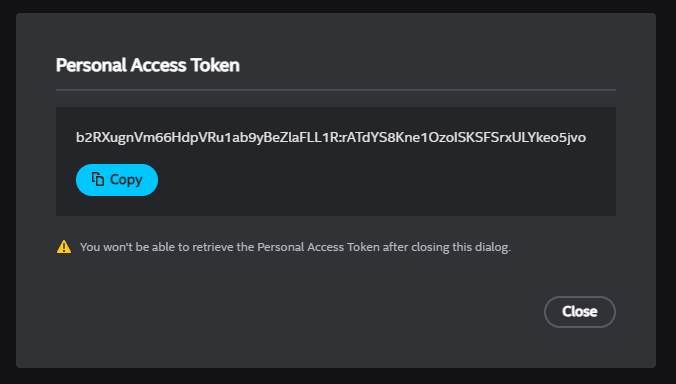

### Step 2.1: Prerequisite Import

In [1]:
from utils import VideoPlayer
from pathlib import Path
import cv2
import glob
import os
import time
from datetime import datetime
import ipywidgets as widgets

### Step 2.2: Define a class for Video Player 

In [ ]:
import threading
import time

class VideoPlayer:
    """
    Custom video player to fulfill FPS requirements. You can set target FPS and output size,
    flip the video horizontally or skip first N frames.

    :param source: Video source. It could be either camera device or video file.
    :param size: Output frame size.
    :param flip: Flip source horizontally.
    :param fps: Target FPS.
    :param skip_first_frames: Skip first N frames.
    """

    def __init__(self, source, size=None, flip=False, fps=None, skip_first_frames=0):
        import cv2

        self.cv2 = cv2  # This is done to access the package in class methods
        self.__cap = cv2.VideoCapture(source)
        self.__cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
        self.__cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
        self.__cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)
        # self.__cap.set(cv2.CAP_PROP_FOCUS, 100)
        # self.__cap.set(cv2.CAP_PROP_SETTINGS, 1)
        if not self.__cap.isOpened():
            raise RuntimeError(
                f"Cannot open {'camera' if isinstance(source, int) else ''} {source}"
            )
        # skip first N frames
        self.__cap.set(cv2.CAP_PROP_POS_FRAMES, skip_first_frames)
        # fps of input file
        self.__input_fps = self.__cap.get(cv2.CAP_PROP_FPS)
        if self.__input_fps <= 0:
            self.__input_fps = 60
        # target fps given by user
        self.__output_fps = fps if fps is not None else self.__input_fps
        self.__flip = flip
        self.__size = None
        self.__interpolation = None
        if size is not None:
            self.__size = size
            # AREA better for shrinking, LINEAR better for enlarging
            self.__interpolation = (
                cv2.INTER_AREA
                if size[0] < self.__cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                else cv2.INTER_LINEAR
            )
        # first frame
        _, self.__frame = self.__cap.read()
        self.__lock = threading.Lock()
        self.__thread = None
        self.__stop = False

    """
    Start playing.
    """

    def start(self):
        self.__stop = False
        self.__thread = threading.Thread(target=self.__run, daemon=True)
        self.__thread.start()

    """
    Stop playing and release resources.
    """

    def stop(self):
        self.__stop = True
        if self.__thread is not None:
            self.__thread.join()
        self.__cap.release()

    def __run(self):
        prev_time = 0
        while not self.__stop:
            t1 = time.time()
            ret, frame = self.__cap.read()
            if not ret:
                break

            # fulfill target fps
            if 1 / self.__output_fps < time.time() - prev_time:
                prev_time = time.time()
                # replace by current frame
                with self.__lock:
                    self.__frame = frame

            t2 = time.time()
            # time to wait [s] to fulfill input fps
            wait_time = 1 / self.__input_fps - (t2 - t1)
            # wait until
            time.sleep(max(0, wait_time))

        self.__frame = None

    """
    Get current frame.
    """

    def next(self):
        import cv2

        with self.__lock:
            if self.__frame is None:
                return None
            # need to copy frame, because can be cached and reused if fps is low
            frame = self.__frame.copy()
        if self.__size is not None:
            frame = self.cv2.resize(frame, self.__size, interpolation=self.__interpolation)
        if self.__flip:
            frame = self.cv2.flip(frame, 1)
        return frame

### Step 3: Connect to Intel® Geti™ Instance using Intel® Geti™ SDK

In [ ]:
from geti_sdk import Geti
from geti_sdk.rest_clients import ProjectClient

#if the system is under a Corp Network, the geti server ip address required to add into 'no_proxy' at the environment.
#e.g. os.environ["no_proxy"]="192.168.0.0/24"

#Provide Geti Server IP and personal access token for the script to access your geti account
# e.g. geti = Geti(host="192.168.1.2", token="LbJkZ9cf8H10QNALJQZn6uTZTahl2mbv:OtZfu4VrigbZJ42jQDVbNtqTAt8uoZoc", verify_certificate=False)
geti = Geti(host="<Geti_Server_IP>", token="<Your_Token>", verify_certificate=False)

### Step 4: Create New Project

In [ ]:
project_name = widgets.Text(
    value='New Project',
    placeholder='Type something',
    description='Project Name:',
    disabled=False
)
project_type = widgets.Dropdown(
    options=['detection'],
    value='detection',
    description='Project Type',
    disabled=False
)
project_labels = widgets.Text(
    value='',
    placeholder='apple, orange, pear',
    description='Labels',
    disabled=False
)
widgets.Box(children=[project_name, project_type, project_labels])

### Step 5: Generate Data for Dataset
We will create a new project from scratch and will upload images using the SDK for further annotations into the Intel® Geti™ Platform.

In [ ]:
player = None
try:
    player = VideoPlayer(source=0, flip=False, fps=30, skip_first_frames=0)
    player.start()
    
    img_count = 0
    Path("images").mkdir(parents=True, exist_ok=True)    
    
    title = "Press ESC to exit, Press C to capture"
    cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
    
    while True:
        frame = player.next()
        if frame is None:
            print("Source ended")
            break
            
        ori_frame = frame.copy()
        image = cv2.putText(frame, f"{img_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA) 
        h, w = frame.shape[:2]
        
        image = cv2.resize(image, (640, 480))
        cv2.imshow(winname=title, mat=image)
        key = cv2.waitKey(1)
        
        if key == 27:
            break
        if key == ord('c'):
            filename = datetime.now().strftime("%m%d%Y%H%M%S")
            cv2.imwrite(f"images/{filename}.png", ori_frame)
            img_count += 1
            time.sleep(0.1)
            
except KeyboardInterrupt:
        print("Interrupted")
    
except RuntimeError as e:
        print(e)
    
finally:
    if player is not None:
        player.stop()
    cv2.destroyAllWindows()

### Step 6: Create Project

In [ ]:
from geti_sdk.rest_clients import ProjectClient

project_client = ProjectClient(
    session=geti.session, workspace_id=geti.workspace_id
)

project = project_client.get_or_create_project(
    project_name=project_name.value, project_type=project_type.value, labels=[[ label for label in project_labels.value.split(",") ]]
)

### Step 7: Upload Dataset

In [ ]:
from geti_sdk.rest_clients import ImageClient
from tqdm import tqdm

image_client = ImageClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)
# for i in tqdm (range(img_count)):
for ind, img in tqdm(enumerate(glob.glob("images/*.png"))):
    image = image_client.upload_image(img)
    os.remove(img)
        # print(image)
print("Images uploaded successfully")

<h1 style="text-align: center"> Login into Intel® Geti™ Instance and Perform Annotations </h1>
<h1 style="text-align: center"> <a href="https://192.168.xx.xx"> https://192.168.xx.xx </a> </h1>

### Step 8: Check Model Training Status

In [ ]:
from geti_sdk.demos import ensure_trained_example_project
ensure_trained_example_project(geti=geti, project_name=project_name.value)

### Step 9: Download Trained Model & Configure Inferencing Deployment

In [ ]:
deployment = geti.deploy_project(project_name=project_name.value)
PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", project_name.value)
deployment.save(path_to_folder=PATH_TO_DEPLOYMENT_FOLDER)

In [ ]:
deployment.load_inference_models(device="CPU")

### Step 10: Run Inferencing

In [ ]:
import collections
import time

import cv2
import numpy as np
from IPython import display
from utils import VideoPlayer

from geti_sdk.utils import show_image_with_annotation_scene


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    fps = 0
    try:
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        title = "Press ESC to Exit"
        cv2.namedWindow(
            winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
        )
        processing_times = collections.deque()
        while True:
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # scale = 1920 / max(frame.shape)
            # if scale < 1:
            scale = 1
            frame = cv2.resize(
                src=frame,
                dsize=None,
                fx=scale,
                fy=scale,
                interpolation=cv2.INTER_AREA,
            )
            input_image = frame.copy()
            input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
            # Measure processing time.

            start_time = time.time()

            # ==========================2. Using Geti SDK predictions========================

            # Get the results.
            prediction = deployment.infer(input_image)
            stop_time = time.time()
            processing_times.append(stop_time - start_time)

            # ==========================3. Sending images back to the platform======================

            # # if the prediction has more than one label send the image back to Intel Geti Platform
            # if len(prediction.annotations) > 1:
            #     # image = image_client.upload_image(input_image)
            #     uploader.add_data(input_image)
            #     print(f"queue = {uploader.queue_length}")

            # ================4. Creating output with bounding boxes, labels, and confidence========
            output = show_image_with_annotation_scene(
                cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), prediction, show_results=False
            )

            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            # print the FPS for your reference
            # print(fps)

            output = cv2.putText(output, f"{fps}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

            cv2.imshow(winname=title, mat=output)
            key = cv2.waitKey(1)
            if key == 27:
                break
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
            cv2.destroyAllWindows()

run_object_detection(0)

## Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation. 

No product or component can be absolutely secure.  

Your costs and results may vary.  

No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document, with the sole exception that code included in this document is licensed subject to the Zero-Clause BSD open source license (0BSD), Open Source Initiative. No rights are granted to create modifications or derivatives of this document. 

© Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.  